## Initial setup

In [1]:
import pandas as pd
import numpy as np
from chardet import detect
import matplotlib.pyplot as plt
import seaborn as sns
import os
import importlib.util
import subprocess
import pandas_dq 
import plotly.express as px
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer, OneHotEncoder

In [2]:
# Defining default visualisation settings
sns.set_theme(palette='inferno')
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
#Configuring LLM for later result interpretations
if 'OPENAI_API_KEY' in os.environ:
    api_key = os.environ['OPENAI_API_KEY']
    from openai import OpenAI
    model,role = "gpt-3.5-turbo","user"
    client = OpenAI(api_key = api_key)
else:
    api_key = None

### Preparing the data

In [4]:
def check_encoding(file: str = None)-> str:
    with open(file, 'rb') as f:
        encoding = detect(f.read(10000))['encoding']
        return encoding

def load_apartments_data(source:str):
    """
    Checks if the file 'apartment_data.csv' exists in the current working directory.
    If not, fetches data using ucimlrepo, saves it as a CSV file, and loads it into a DataFrame.
    Returns a DataFrame `apartments_source`.
    """
    file_name = "apartment_data.csv"

    # Check if the ucimlrepo package is installed
    if importlib.util.find_spec("ucimlrepo") is None:
        print("The 'ucimlrepo' package is not installed. Installing it now...")
        subprocess.check_call(["pip", "install", "ucimlrepo"])
        print("Installation complete.")

    if not os.path.exists(file_name):
        print(f"The file '{file_name}' does not exist. Fetching data...")
        # Install ucimlrepo (requires an internet connection)
        try:
            import ucimlrepo
        except ImportError:
            os.system("pip install ucimlrepo")
            from ucimlrepo import fetch_ucirepo
        # Fetching data from the UC Irvine repository
        from ucimlrepo import fetch_ucirepo
        apartment_for_rent_classified = fetch_ucirepo(id=555)

        # Preparing the data
        X = apartment_for_rent_classified.data.features
        y = apartment_for_rent_classified.data.targets

        # Combining features and targets into one DataFrame
        apartments_source = pd.concat([X, y], axis=1)

        # Saving to CSV
        apartments_source.to_csv(file_name, index=False)
        print(f"Data has been fetched and saved to the file '{file_name}'.")
    else:
        print(f"The file '{file_name}' already exists. Loading data...")

    # Loading data into a DataFrame
    apartments_source = pd.read_csv(source, encoding=check_encoding(source),low_memory=False,
                                    encoding_errors = 'ignore',
                                    delimiter=',')
    return apartments_source

apartments_source = load_apartments_data("apartment_data.csv")


The file 'apartment_data.csv' already exists. Loading data...


In [5]:
#Leaving original data aside
apartments = apartments_source.copy()

## Data exploration

In [6]:
#Exploring basic properties of the dataframe
def describe_df(df: pd.DataFrame)-> None:
    """
    Given a dataframe, the function calls some most popular data exploration functions at once.
    :param df: 
    :return: None 
    """
    describe_functions = [(lambda df: df.head(5), "Head(5):"),
        (pd.DataFrame.describe, "Describe:"),
        (pd.DataFrame.info, "Info:"),
        (lambda df: df.isnull().sum()[df.isnull().sum() > 0],"Null values:")]
    
    for func,name in describe_functions:
        print(f"\n Applying function: {name}",end = "\n")
        print(func(df))
        
describe_df(apartments)


 Applying function: Head(5):
          category                     title                \
0  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  housing/rent/apartment      Three BR 146 Lochview Drive   
2  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  housing/rent/apartment            Two BR 209 Aegean Way   
4  housing/rent/apartment         One BR 4805 Marquette NE   

                                                                               body                                                                              \
0             This unit is located at 507 & 509 Esplanade, Redondo Beach, 90277, CAMonthly rental rates range from $2195We have 1 beds units available for rent   
1               This unit is located at 146 Lochview Drive, Newport News, 23602, VAMonthly rental rates range from $1250We have 3 beds units available for rent   
2                This unit is located at 3101 Morningside Drive, Raleigh, 27607, NCMonthly rental rates rang

In [7]:
pandas_dq.dq_report(apartments,verbose=1)

There are 84 duplicate rows in your dataset
    Alert: Dropping duplicate rows can sometimes cause your column data types to change to object!
    All variables classified into correct types.


C:\Users\mijanisz\AppData\Local\Temp\5\ipykernel_13548\2014033892.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pandas_dq.dq_report(apartments,verbose=1)


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
category,object,0.000000,0,,,"9 rare categories: ['housing/rent/commercial/retail', 'housing/rent', 'housing/rent/home', 'housing/rent/short_term', 'housing/rent/condo', 'Parking,Patio/Deck', 'Gym', 'housing/rent/other', '2']. Group them into a single category or drop the categories."
title,object,0.000000,58,,,No issue
body,object,0.000000,95,,,No issue
amenities,object,16.108560,9,,,"16067 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: float, object,"
bathrooms,object,0.066171,0,,,"66 missing values. Impute them with mean, median, mode, or a constant value such as 123., 18 rare categories: Too many to list. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
bedrooms,object,0.127329,0,,,"127 missing values. Impute them with mean, median, mode, or a constant value such as 123., 15 rare categories: Too many to list. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
currency,object,0.004010,0,,,"4 missing values. Impute them with mean, median, mode, or a constant value such as 123., 2 rare categories: ['Cats,Dogs', '1019']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
fee,object,0.003008,0,,,"3 missing values. Impute them with mean, median, mode, or a constant value such as 123., 4 rare categories: ['Yes', '1380', '2150', '1019']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
has_photo,object,0.003008,0,,,"3 missing values. Impute them with mean, median, mode, or a constant value such as 123., 3 rare categories: ['1380', '2150', 'Monthly']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
pets_allowed,object,60.740711,0,,,"60584 missing values. Impute them with mean, median, mode, or a constant value such as 123., 4 rare categories: ['Dogs', 'Monthly', '823', 'Cats,Dogs,None']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
category,object,0.000000,0,,,"9 rare categories: ['housing/rent/commercial/retail', 'housing/rent', 'housing/rent/home', 'housing/rent/short_term', 'housing/rent/condo', 'Parking,Patio/Deck', 'Gym', 'housing/rent/other', '2']. Group them into a single category or drop the categories."
title,object,0.000000,58,,,No issue
body,object,0.000000,95,,,No issue
amenities,object,16.108560,9,,,"16067 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: float, object,"
bathrooms,object,0.066171,0,,,"66 missing values. Impute them with mean, median, mode, or a constant value such as 123., 18 rare categories: Too many to list. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
bedrooms,object,0.127329,0,,,"127 missing values. Impute them with mean, median, mode, or a constant value such as 123., 15 rare categories: Too many to list. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
currency,object,0.004010,0,,,"4 missing values. Impute them with mean, median, mode, or a constant value such as 123., 2 rare categories: ['Cats,Dogs', '1019']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
fee,object,0.003008,0,,,"3 missing values. Impute them with mean, median, mode, or a constant value such as 123., 4 rare categories: ['Yes', '1380', '2150', '1019']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
has_photo,object,0.003008,0,,,"3 missing values. Impute them with mean, median, mode, or a constant value such as 123., 3 rare categories: ['1380', '2150', 'Monthly']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"
pets_allowed,object,60.740711,0,,,"60584 missing values. Impute them with mean, median, mode, or a constant value such as 123., 4 rare categories: ['Dogs', 'Monthly', '823', 'Cats,Dogs,None']. Group them into a single category or drop the categories., Mixed dtypes: has 2 different data types: object, float,"


In [8]:
#Checking if there are other currencies than USD used
apartments['currency'].value_counts()

currency
USD          99820
Cats,Dogs        1
1019             1
Name: count, dtype: int64

In [9]:
# Deleting incorrect rows where Currency is 'Cats,Dogs' or ' 1019'
apartments = apartments[~apartments['currency'].isin(['Cats,Dogs', '1019'])]
#Removing unnecessary columns
apartments.drop(columns=['category','title','body','has_photo','source','time','price_display','currency','cityname','price_type'], inplace=True)
#Proper formatting of the columns
apartments.columns = apartments.columns.str.capitalize()
#Dropping duplicates
apartments.drop_duplicates(inplace=True)

In [10]:
#Converting numerical columns to float from objects
apartments[apartments['Bathrooms']=='No'] = np.nan
apartments[apartments['Bathrooms']=='Thumbnail'] = np.nan
apartments = apartments.astype({'Bathrooms':float,"Bedrooms":float,"Square_feet":float})
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91053 entries, 0 to 99825
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Amenities     75958 non-null  object 
 1   Bathrooms     90989 non-null  float64
 2   Bedrooms      90935 non-null  float64
 3   Fee           91051 non-null  object 
 4   Pets_allowed  36065 non-null  object 
 5   Price         91050 non-null  float64
 6   Square_feet   91051 non-null  float64
 7   Address       7940 non-null   object 
 8   State         90784 non-null  object 
 9   Latitude      91026 non-null  float64
 10  Longitude     91026 non-null  float64
dtypes: float64(6), object(5)
memory usage: 8.3+ MB


In [11]:
#Handling nulls: there are lots of empty values for pets and amenities, so I leave them in the model, but only small amount of other missing values, so I drop the other features
apartments['Pets_allowed'] = apartments['Pets_allowed'].fillna('Unknown')
apartments['Amenities'] = apartments['Amenities'].fillna('None')
apartments.dropna(subset=['Bathrooms','Bedrooms','Price','Latitude','Longitude','State'],inplace=True)
apartments.drop('Address',axis=1,inplace=True)
apartments = apartments.drop_duplicates()

In [12]:
#% of records left from the original df
print(f' % of the data set left after dropping nulls: {(apartments.shape[0]/apartments_source.shape[0]).__format__(".2f")}'
)

 % of the data set left after dropping nulls: 0.89


##### Removing 'state' and replacing it with 'population' to easier handle the categorical values. Getting the population data and state full names from onlines sources.

In [13]:
#Loading a table containing US division into regions
url_states_csv = "https://raw.githubusercontent.com/MichauJ/Learning-ML/main/Data/US_states.csv"
US_states_source = "US_states.csv"
US_states = pd.read_csv(url_states_csv,delimiter=";") #encoding=check_encoding(US_states_source)
US_states.loc[US_states['State'] == 'Washington, D.C.', 'State'] = 'District of Columbia'

In [14]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population" #data of US population by states
url2 = "https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/" #table of the states' abbreviatons
# Extract all tables from the page
tables = pd.read_html(url)
# Reading the table containing population data for each state
state_population = tables[0]
state_population = state_population[[('State or territory','State or territory'),('Census population[8][9][a]','July 1, 2024 (est.)')]]
state_population.columns = state_population.columns.get_level_values(1) #the table is a multindex one, reading only column values from level 1
state_population.rename(columns = {'July 1, 2024 (est.)':'Population','State or territory':'State'},inplace=True)
#Creating table with US states full names and abbreviations
abbr_table = pd.read_html(url2,header=0)[0]
abbr_table.rename(columns = {'Full Name':'State',"2-letter USPS":"Code"},inplace=True)

C:\Users\mijanisz\AppData\Local\Temp\5\ipykernel_13548\328146636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_population.rename(columns = {'July 1, 2024 (est.)':'Population','State or territory':'State'},inplace=True)


In [15]:
#Finally merging the tables to gain data of population in the original table
state_population = state_population.merge(abbr_table,on = 'State',how = 'left').merge(US_states,on = "State", how = 'left' )
state_population.dropna(subset = 'Code', inplace = True)
state_population.drop(columns = 'Traditional Abbreviation',inplace = True)
apartments = apartments.merge(state_population,left_on = 'State',right_on = 'Code',how = 'left')
apartments.drop(columns = ['State_x','Code'],inplace = True)

In [16]:
apartments.head(3)

,Amenities,Bathrooms,Bedrooms,Fee,Pets_allowed,Price,Square_feet,Latitude,Longitude,State_y,Population,Division,Region
0,None,1.0,1.0,No,Cats,2195.0,542.0,33.8520,-118.3759,California,39431263.0,Pacific,West
1,None,1.5,3.0,No,"Cats,Dogs",1250.0,1500.0,37.0867,-76.4941,Virginia,8811195.0,South Atlantic,South
2,None,2.0,3.0,No,Unknown,1395.0,1650.0,35.8230,-78.6438,North Carolina,11046024.0,South Atlantic,South


In [17]:
fig = px.treemap(
    apartments.assign(LogPopulation=np.log(apartments['Population'])),
    path=['Region', 'Division', 'State_y'],  # hierarchy
    values='LogPopulation',  # base for size of the rectangles
    color='Population',
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        'Region': 'Region',
        'Division': 'Division',
        'State_y': 'State',
        'Population': 'Population'
    },
    title="Interactive treemap of US division, sizes based on the population counts of each state"
)
fig.update_layout(
    width=1300,
    height=600)
fig.update_layout(
    showlegend=False,
    annotations=[
        dict(
            x=0.01,
            y=-0.05,
            text="Division adopted after US Census Bureau",
            showarrow=False,
            font=dict(size=10, color="white"),
            align="left")])
fig.show()

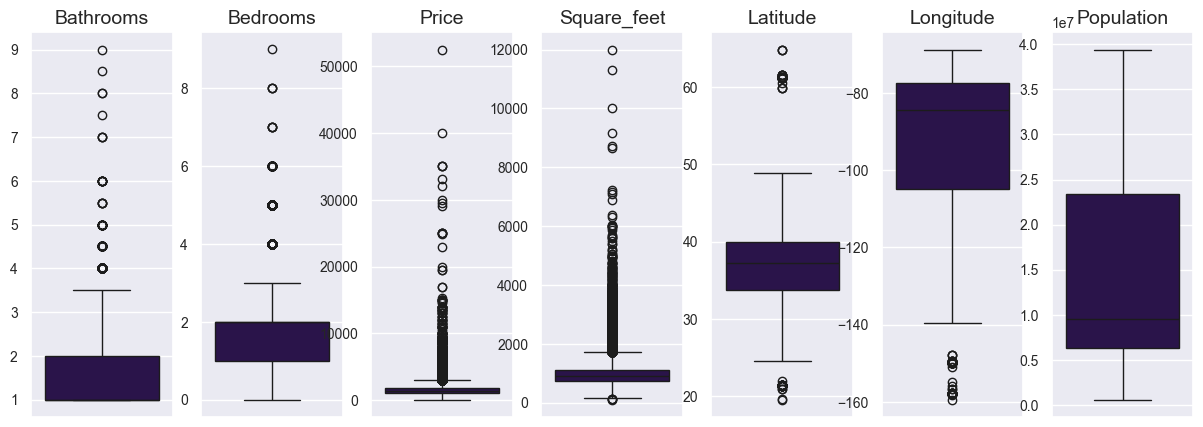

In [18]:
# Box plots of all the features
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)

for i, column in enumerate(num_apartments.columns):
    sns.boxplot(data=num_apartments, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel("") 
plt.show()

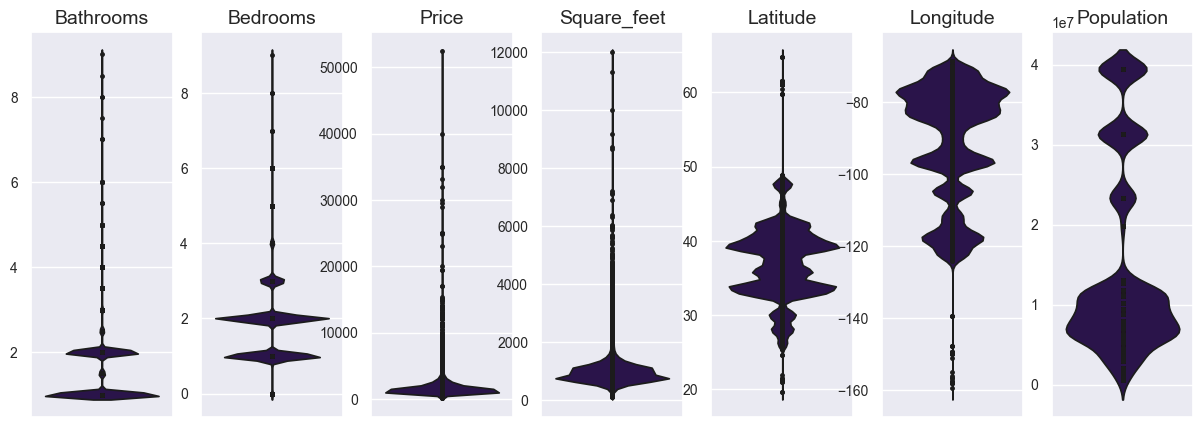

In [19]:
# Violin plots
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)
for i, column in enumerate(num_apartments.columns):
    sns.violinplot(data=num_apartments, y=column, ax=axes[i], inner="point")
    axes[i].set_title(column)
    axes[i].set_ylabel("")
plt.show()

In [20]:
#Checking the proportions of values in Bedrooms and States
bedrooms_ratios = apartments['Bedrooms'].value_counts()/apartments.shape[0]*100
bedrooms_ratios.sort_index(inplace=True,ascending=True)
states_ratios = apartments['State_y'].value_counts()/apartments.shape[0]*100
regions_ratios = apartments['Region'].value_counts()/apartments.shape[0]*100
print(regions_ratios)

Region
South        42.963569
West         25.892857
Northeast    18.732076
Midwest      12.411498
Name: count, dtype: float64


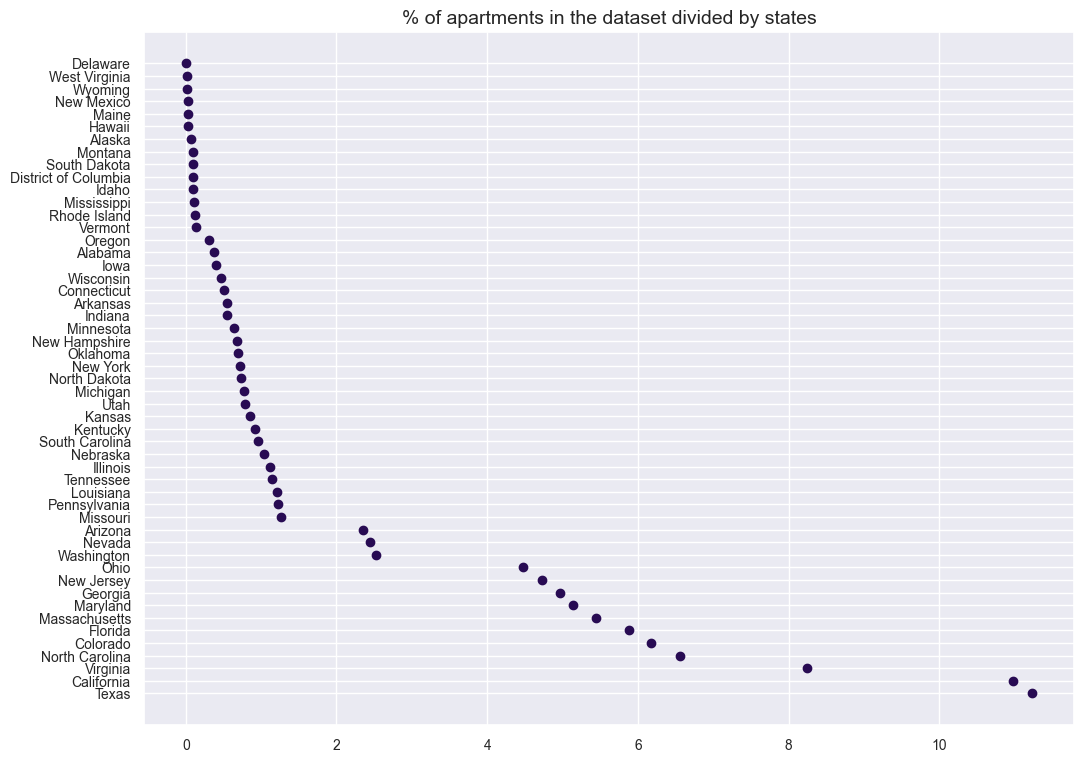

In [21]:
#Visualising
plt.figure(figsize=(12,9))
plt.scatter(states_ratios,
    states_ratios.index)
plt.title('% of apartments in the dataset divided by states')
plt.show()
    

<Axes: title={'center': '% of apartments by number of bedrooms'}, xlabel='Bedrooms'>

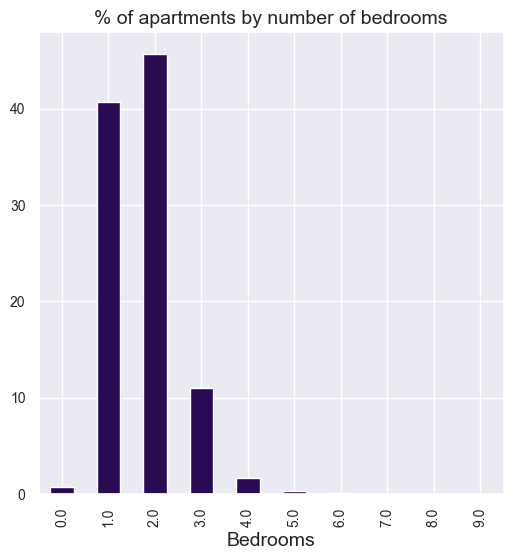

In [22]:
bedrooms_ratios.plot(kind='bar', stacked=False, figsize=(6, 6),title="% of apartments by number of bedrooms")


Text(0, 0.5, '')

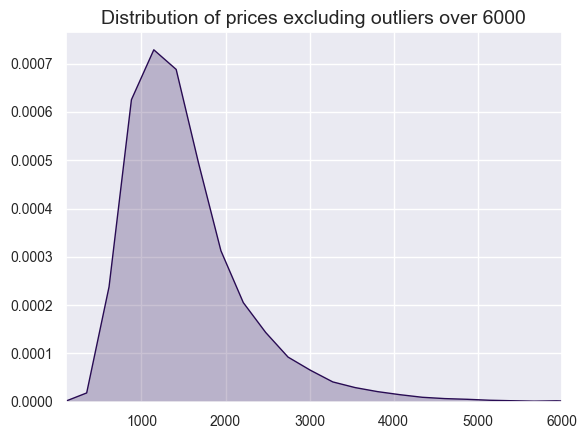

In [23]:
#Checking the distribution of prices in the dataset
plot = sns.kdeplot(data = apartments,
            x = 'Price',fill=True)
plot.set(xlim=(min(apartments['Price']),6000))
plot.set_title("Distribution of prices excluding outliers over 6000")
plot.set_xlabel("")
plot.set_ylabel("")

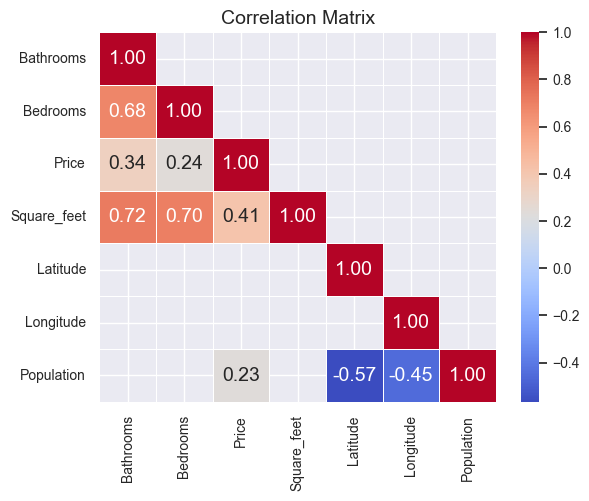

In [24]:
#Creating a correlation matrix, removing double entries to receive a lower triangular matrix
correlation_matrix = apartments.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
masked_correlation_matrix = correlation_matrix.mask(mask).where(abs(correlation_matrix) > 0.2) #setting a limit so to not display irrelevant correlations
np.fill_diagonal(masked_correlation_matrix.values, 1)
sns.heatmap(masked_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

array([[<Axes: xlabel='Price', ylabel='Price'>,
        <Axes: xlabel='Square_feet', ylabel='Price'>,
        <Axes: xlabel='Population', ylabel='Price'>],
       [<Axes: xlabel='Price', ylabel='Square_feet'>,
        <Axes: xlabel='Square_feet', ylabel='Square_feet'>,
        <Axes: xlabel='Population', ylabel='Square_feet'>],
       [<Axes: xlabel='Price', ylabel='Population'>,
        <Axes: xlabel='Square_feet', ylabel='Population'>,
        <Axes: xlabel='Population', ylabel='Population'>]], dtype=object)

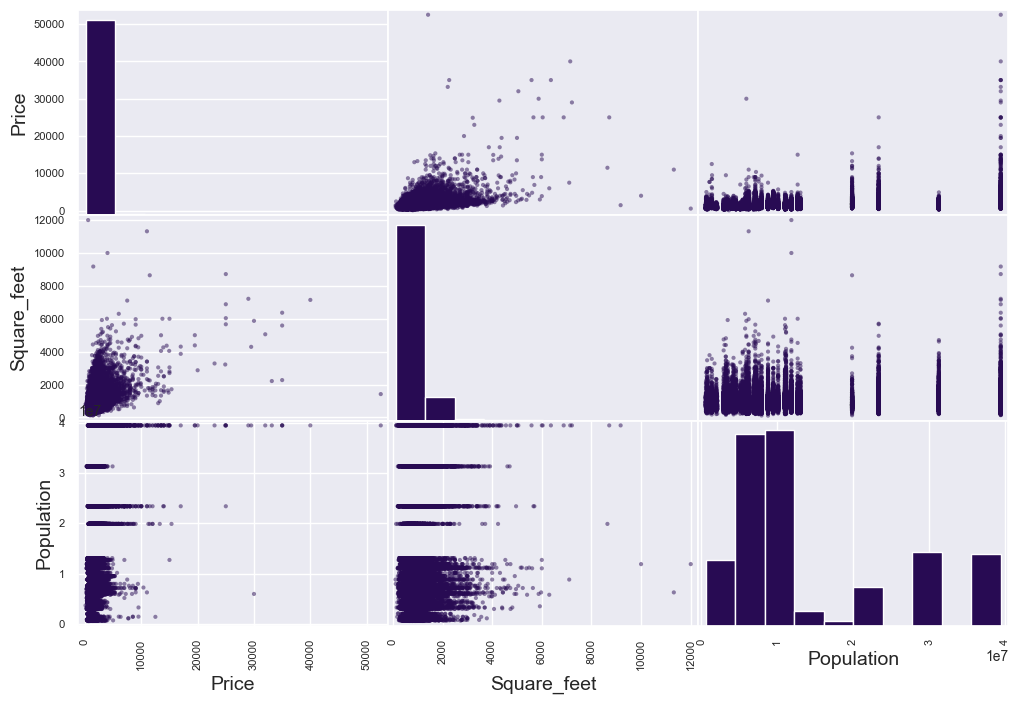

In [25]:
scatter_matrix(apartments[['Price','Square_feet','Population']],figsize=(12,8))

### Preparing data for machine learning

#### Data cleaning

In [26]:
#Confirming the amount of null values is 0
assert apartments.isnull().sum().sum() == 0, "There are some missing values in the dataframe."

#### Handling text and categorical data

In [27]:
# Extracting all values from Amenities column and making separate 1/0 columns for each amenity separately
all_amenities = set()
apartments['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
#apartments_test['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
for amenity in all_amenities:
    apartments[amenity] = apartments['Amenities'].apply(lambda x: 1 if amenity in x.split(',') else 0)

In [28]:
# Separating data on pets to 1/0 encoding
all_pets = set()
apartments['Pets_allowed'].dropna().apply(lambda x: all_pets.update(x.split(',')))
for pet in all_pets:
    apartments[pet] = apartments['Pets_allowed'].apply(lambda x: 1 if pet in x.split(',') else 0)


In [29]:
#Dropping unnecessary columns and renaming some new ones for clarity
apartments.drop(columns = ['Pets_allowed','Amenities','State_y','Unknown'],inplace=True)
apartments.rename({"None":"No amenities","Dogs":"Dogs_allowed","Cats":"Cats_allowed"}, axis=1, inplace=True)


In [30]:
# Transforming Fee from yes/no to 1/0
apartments['Fee'] = apartments['Fee'].map({"Yes":1, "No":0})


In [31]:
#One hot encoding for States and regions
apartments_cat = apartments.select_dtypes(object)
cat_encoder = OneHotEncoder()
apartments_cat_1hot = cat_encoder.fit_transform(apartments_cat)
#converting results to a dataframe
apartments_cat_1hot_df = pd.DataFrame(apartments_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(apartments_cat.columns))
# adding to the original data frame
apartments = pd.concat([apartments, apartments_cat_1hot_df], axis=1)

In [32]:
apartments.drop(columns=['Region','Division'],inplace = True)

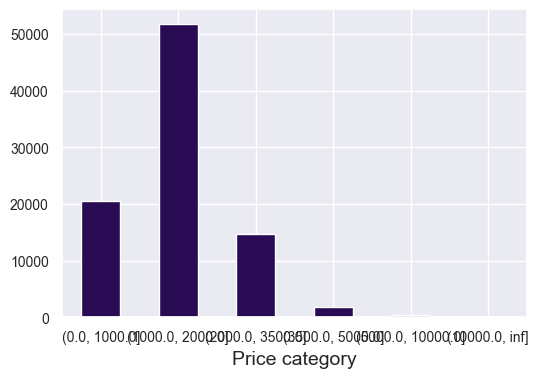

In [33]:
#Grouping size categories so the division can be used to take the stratified sample
bins = [0,1000,2000,3500,5000,10000,np.inf]
apartments['Price category'] = pd.cut(apartments['Price'],
                                      bins = bins
                                      )
apartments["Price category"].value_counts().sort_index().plot.bar(rot = 0, grid=True,figsize=(6,4))
plt.xlabel("Price category")
plt.show()

In [34]:
apartments.head(1)

,Bathrooms,Bedrooms,Fee,Price,Square_feet,Latitude,Longitude,Population,Pool,Wood Floors,Washer Dryer,Patio/Deck,Cable or Satellite,Playground,View,Clubhouse,Elevator,Internet Access,Parking,Tennis,Dishwasher,Golf,Alarm,Fireplace,No amenities,TV,Refrigerator,Garbage Disposal,AC,Luxury,Hot Tub,Gated,Doorman,Gym,Basketball,Storage,Cats_allowed,Dogs_allowed,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central,Region_Midwest,Region_Northeast,Region_South,Region_West,Price category
0,1.0,1.0,0,2195.0,542.0,33.852,-118.3759,39431263.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(2000.0, 3500.0]"


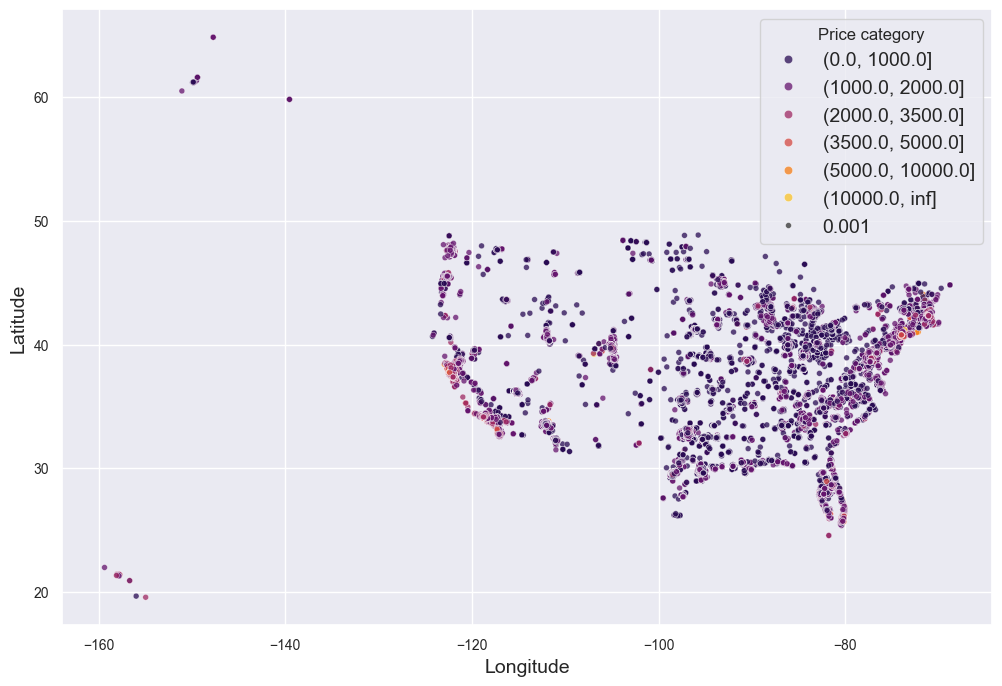

In [35]:
# plotting a scatter plot to check if there is any visible relation between localisation and the houses' size 
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Price category',
    data=apartments,
    alpha=0.75,
    size=0.001,
    legend = 'brief',
palette='inferno')


#### Feature scaling

#### Normalisation

In [36]:
apartments_to_normalize = apartments.drop(columns=['Price','Price category'])

In [37]:
apartments_to_normalize.head()

,Bathrooms,Bedrooms,Fee,Square_feet,Latitude,Longitude,Population,Pool,Wood Floors,Washer Dryer,Patio/Deck,Cable or Satellite,Playground,View,Clubhouse,Elevator,Internet Access,Parking,Tennis,Dishwasher,Golf,Alarm,Fireplace,No amenities,TV,Refrigerator,Garbage Disposal,AC,Luxury,Hot Tub,Gated,Doorman,Gym,Basketball,Storage,Cats_allowed,Dogs_allowed,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central,Region_Midwest,Region_Northeast,Region_South,Region_West
0,1.0,1.0,0,542.0,33.8520,-118.3759,39431263.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.5,3.0,0,1500.0,37.0867,-76.4941,8811195.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,3.0,0,1650.0,35.8230,-78.6438,11046024.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,2.0,0,820.0,38.3622,-121.9712,39431263.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0,624.0,35.1038,-106.6110,2130256.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
apartments.to_csv("apartments_for_clustering.csv")

In [ ]:
#In case transformation does not require any training, sklearn can be used to transform a feature like in the example
log_transformer = FunctionTransformer(np.log,inverse_func=np.exp)
log_population = log_transformer.transform(apartments_to_normalize[['Population']])

In [ ]:
apartments_num = apartments_to_normalize.select_dtypes(include='number')
#when scaling sparse matrix without transforming  into dense one, subtracting mean during the standardization might be skipped, because otherwise it would thwart the matrix's sparsity
#Here I choose mixed approach to standardization, meaning treating separately sparse and dense part of the matrix
dense_columns,sparse_columns = (apartments_num.columns[apartments_num.nunique() > 2],
    apartments_num.columns[apartments_num.nunique() == 2])
apartments_num_std_scaled = apartments_num.copy()
sparse_scaler = StandardScaler(with_mean=False)
apartments_num_std_scaled[sparse_columns] = sparse_scaler.fit_transform(apartments_num[sparse_columns])

dense_scaler = StandardScaler(with_mean=True)
apartments_num_std_scaled[dense_columns] = dense_scaler.fit_transform(apartments_num[dense_columns])

In [73]:
apartments_num_std_scaled[['Price','Price category']] = apartments[['Price','Price category']]

## Create a Test Set

#### Stratified shuffle split

In [ ]:
# Splitting the data to train and test
train_set,test_set = train_test_split(
    apartments_num_std_scaled,test_size=0.2,random_state=42,stratify = apartments['Price category']
)
#Comparison of % of values in original dataset and the stratified sample
(train_set['Price category'].value_counts()/len(train_set),
 apartments['Price category'].value_counts()/len(apartments))

(Price category
 (1000.0, 2000.0]     0.580541
 (0.0, 1000.0]        0.229867
 (2000.0, 3500.0]     0.164723
 (3500.0, 5000.0]     0.019563
 (5000.0, 10000.0]    0.004509
 (10000.0, inf]       0.000798
 Name: count, dtype: float64,
 Price category
 (1000.0, 2000.0]     0.580536
 (0.0, 1000.0]        0.229869
 (2000.0, 3500.0]     0.164725
 (3500.0, 5000.0]     0.019571
 (5000.0, 10000.0]    0.004503
 (10000.0, inf]       0.000795
 Name: count, dtype: float64)

In [75]:
#Dropping price category as it won't be useful anymore
train_set_labels = train_set['Price'].copy()
test_set_labels = test_set['Price'].copy()
train_set.drop(columns = ["Price category","Price"],inplace = True)
test_set.drop(columns = ["Price category","Price"],inplace = True)

#### Training and validating the model

In [76]:
#Testing if all values in the train set are numerical
assert all(train_set.dtypes.apply(lambda x: x.kind in 'iuf')), "There are still some features that are not numerical"
model_results = {}

#####  1.Linear regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train_set, train_set_labels)
apartments_predictions_lr = lin_reg.predict(train_set)
lin_rmse,linr2 = root_mean_squared_error(train_set_labels, apartments_predictions_lr),r2_score(train_set_labels, apartments_predictions_lr)
interquartile_range = np.percentile(train_set_labels,75)-np.percentile(train_set_labels,25)
model_results['LinearRegression'] = {"RMSE": lin_rmse,"R2":linr2}
print(f"RMSE of linear regression model: {lin_rmse}, R2: {linr2} for the dataset of: \n{train_set_labels.describe()}")

RMSE of linear regression model: 704.3752412380146, R2: 0.433379580974262 for the dataset of: 
count    71411.000000
mean      1556.989133
std        935.752535
min        100.000000
25%       1035.000000
50%       1375.000000
75%       1826.000000
max      52500.000000
Name: Price, dtype: float64


In [78]:
if api_key is not None:
    interpretation_lr = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f"Interpret the results of the model: {lin_reg},RMSE: {lin_rmse}, for the dataset of: \n{train_set_labels.describe()}"}]                                                    )
    print(interpretation_lr.choices[0].message.content)
else:
    print("ChatGPT's interpretation is not available unless api key is provided")

ChatGPT's interpretation is not available unless api key is provided


In [79]:
# Showing directly some predictions compared to labels
pd.DataFrame({"Predictions":apartments_predictions_lr[:5].round(2),"Labels": train_set_labels[:5].round(2)})

,Predictions,Labels
40016,1535.76,1415.0
6718,667.62,795.0
62170,912.46,696.0
49607,2059.11,1695.0
811,519.34,888.0


### 2. Polynomial regression

In [ ]:
# Tworzymy pipeline: PolynomialFeatures + LinearRegression
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(train_set, train_set_labels)
apartments_predictions_lr = poly_model.predict(train_set)
poly_lin_rmse = root_mean_squared_error(train_set_labels, apartments_predictions_lr)
poly_linr2 = r2_score(train_set_labels, apartments_predictions_lr)

# Interquartile Range
interquartile_range = np.percentile(train_set_labels, 75) - np.percentile(train_set_labels, 25)

# Zapis do słownika wyników
model_results['Polynomial (2) LinearRegression'] = {"RMSE": poly_lin_rmse, "R2": poly_linr2}

# Wydruk wyników
print(f"RMSE of linear regression model: {poly_lin_rmse:.2f}, R2: {poly_linr2:.2f} for the dataset of: \n{train_set_labels.describe()}")

RMSE of linear regression model: 590.28, R2: 0.60 for the dataset of: 
count    71411.000000
mean      1556.989133
std        935.752535
min        100.000000
25%       1035.000000
50%       1375.000000
75%       1826.000000
max      52500.000000
Name: Price, dtype: float64


In [ ]:
poly_l2_regmodel = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.5))
poly_l2_regmodel.fit(train_set, train_set_labels)
apartments_predictions_lr = poly_l2_regmodel.predict(train_set)
poly_l2_reglin_rmse = root_mean_squared_error(train_set_labels, apartments_predictions_lr)
poly_l2_reglinr2 = r2_score(train_set_labels, apartments_predictions_lr)

# Interquartile Range
interquartile_range = np.percentile(train_set_labels, 75) - np.percentile(train_set_labels, 25)

# Zapis do słownika wyników
model_results['polynomial (3) LinearRegression'] = {"RMSE": poly_l2_reglin_rmse, "R2": poly_l2_reglinr2}

# Wydruk wyników
print(f"RMSE of linear regression model: {poly_l2_reglin_rmse:.2f}, R2: {poly_l2_reglinr2:.2f} for the dataset of: \n{train_set_labels.describe()}")
pd.DataFrame(model_results)

RMSE of linear regression model: 590.28, R2: 0.60 for the dataset of: 
count    71411.000000
mean      1556.989133
std        935.752535
min        100.000000
25%       1035.000000
50%       1375.000000
75%       1826.000000
max      52500.000000
Name: Price, dtype: float64


,LinearRegression,Polynomial (2) LinearRegression,polynomial (3) LinearRegression
RMSE,704.375241,590.283970,590.284474
R2,0.433380,0.602071,0.602070


##### 2. Decision Tree Regressor

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set, train_set_labels)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [83]:
apartments_predictions_dt = tree_reg.predict(train_set)
dt_rmse = root_mean_squared_error(train_set_labels, apartments_predictions_dt)
dt_r2 = r2_score(train_set_labels, apartments_predictions_dt)
model_results['Decision Tree'] = {"RMSE": dt_rmse, "R2": dt_r2}
pd.DataFrame(model_results)

,LinearRegression,Polynomial (2) LinearRegression,polynomial (3) LinearRegression,Decision Tree
RMSE,704.375241,590.283970,590.284474,37.850914
R2,0.433380,0.602071,0.602070,0.998364


In [ ]:
# Using cross validation to assess the decision tree model more precisely as the result of 36,5 is suspicious and it might have been overfitted.

#The cross validation function in sklearn expects utility function instead of the cost function, so "-" has to be added to receive RMSE scores in this case
tree_rmses = -cross_val_score(
    tree_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10
)
pd.Series(tree_rmses).describe()
print(
    f"model: {tree_reg},\nRMSE: {dt_rmse}, \nCross validation results: {tree_rmses}."
)

model: DecisionTreeRegressor(random_state=42),
RMSE: 37.8509139059357, 
Cross validation results: [686.84866513 657.38887746 592.93101315 524.46609324 823.67998403
 592.28839181 632.70342279 554.85374742 584.63685719 494.30622584].


In [85]:
if api_key is not None:
    interpretation_dt = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" model: {tree_reg},RMSE: {dt_rmse}, Cross validation results: {tree_rmses}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}]
                                                    )
    print(interpretation_dt.choices[0].message.content)

#### 3. Random forest regressor

In [ ]:
forest_reg = RandomForestRegressor(random_state =42)
forest_rmses = -cross_val_score(forest_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10)
model_results['Random Forest Regressor'] = {"RMSE": dt_rmse, "R2": dt_r2}
pd.DataFrame(model_results)
pd.Series(forest_rmses).describe()

count     10.000000
mean     460.700129
std      115.270347
min      335.868631
25%      412.855026
50%      433.259444
75%      476.272178
max      756.721766
dtype: float64

In [87]:
if api_key is not None:
    interpretation_rf = client.chat.completions.create(model = model,messages = [
    {"role":role,
     "content" : f" model: {forest_reg},RMSE: {forest_rmses}, Cross validation results: {pd.Series(forest_rmses).describe()}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}])
    print(interpretation_rf.choices[0].message.content)


#### Tuning the model (going with model 3) - with random search method

In [ ]:
param_dist = {
    'n_estimators': np.arange(50, 301, 50),  # number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # features taken into consideration
    'max_depth': [None, 10, 20, 30, 40, 50],  # max trees depth
    'min_samples_split': [2, 5, 10],  # min samples to take
    'min_samples_leaf': [1, 2, 4],  # min samples in the leaves
    'bootstrap': [True, False]
}

forest_reg = RandomForestRegressor(random_state=42)

# random searchin with 10-fold cross-validation
random_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=10,  # number of folds
    verbose=2,  # level of information taken into account
    random_state=42,
    n_jobs=-1  # using all cpu cores
)
random_search.fit(train_set, train_set_labels)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\mijanisz\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mijanisz\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mijanisz\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\mijanisz\AppData\R

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [99]:
best_params = random_search.best_params_
best_rmse = -random_search.best_score_
best_forest_model = random_search.best_estimator_
importances = best_forest_model.feature_importances_

indices = importances.argsort()[::-1]
print("Feature ranking:")
for i in range(len(importances)):
    print(f"{apartments_num_std_scaled.columns[indices[i]]}: {importances[indices[i]]:.4f}")

final_predictions = best_forest_model.predict(train_set)
final_rmse = root_mean_squared_error(train_set_labels, final_predictions)
r2_best_forest = r2_score(train_set_labels, final_predictions)
print("Final RMSE on full data: ", final_rmse, "Final R2 score", r2_best_forest)

Feature ranking:
Square_feet: 0.1884
Longitude: 0.1590
Latitude: 0.1347
Bathrooms: 0.1278
Population: 0.0853
Bedrooms: 0.0510
Division_Pacific: 0.0473
Region_Northeast: 0.0163
Region_West: 0.0158
Region_South: 0.0107
Pool: 0.0089
Elevator: 0.0087
Gym: 0.0082
Parking: 0.0077
Region_Midwest: 0.0073
Division_Middle Atlantic: 0.0068
Patio/Deck: 0.0067
AC: 0.0066
Washer Dryer: 0.0059
Division_Mountain: 0.0058
Division_West North Central: 0.0057
Division_New England: 0.0054
Fireplace: 0.0054
Wood Floors: 0.0052
Dogs_allowed: 0.0047
Playground: 0.0047
Refrigerator: 0.0047
Storage: 0.0041
Division_West South Central: 0.0041
Cats_allowed: 0.0040
Clubhouse: 0.0039
Dishwasher: 0.0039
Doorman: 0.0038
Tennis: 0.0037
Cable or Satellite: 0.0037
Gated: 0.0036
Division_East North Central: 0.0036
Division_South Atlantic: 0.0034
Internet Access: 0.0030
TV: 0.0023
Hot Tub: 0.0021
View: 0.0019
Basketball: 0.0014
Garbage Disposal: 0.0011
Division_East South Central: 0.0010
Fee: 0.0004
Alarm: 0.0003
Luxury: 

### Testing the model on the test data

In [101]:
Y_test,X_test = (test_set_labels.copy(),
                 test_set.copy())
final_predictions_test = best_forest_model.predict(X_test)
final_test_rmse = root_mean_squared_error(Y_test,final_predictions_test)
final_r2_best_forest = r2_score(Y_test,final_predictions_test)
print(f" Final test RMSE: {final_test_rmse}"," Final test r2: ",final_r2_best_forest)

 Final test RMSE: 391.2692418186719  Final test r2:  0.805783037691847


In [ ]:
#Calculating the confidence interval
confidence = 0.95
squared_errors = (final_predictions_test - Y_test) ** 2
confidence_interval = np.sqrt (stats.t.interval(
    confidence, len(squared_errors)-1,loc = squared_errors.mean(),
    scale  = stats.sem(squared_errors)
)
)

Text(0.5, 0, '')

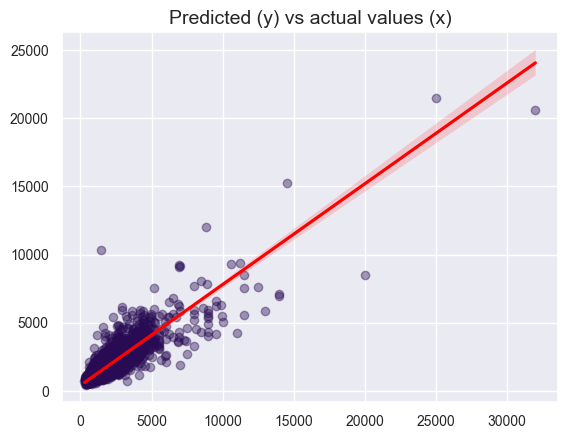

In [103]:
model_effectivness_plot = sns.regplot(
    y = final_predictions_test,
    x = Y_test,
    scatter_kws= {"alpha":0.4},
    line_kws={'color': 'red'},
)
model_effectivness_plot.set_title("Predicted (y) vs actual values (x)")
model_effectivness_plot.set_xlabel("")

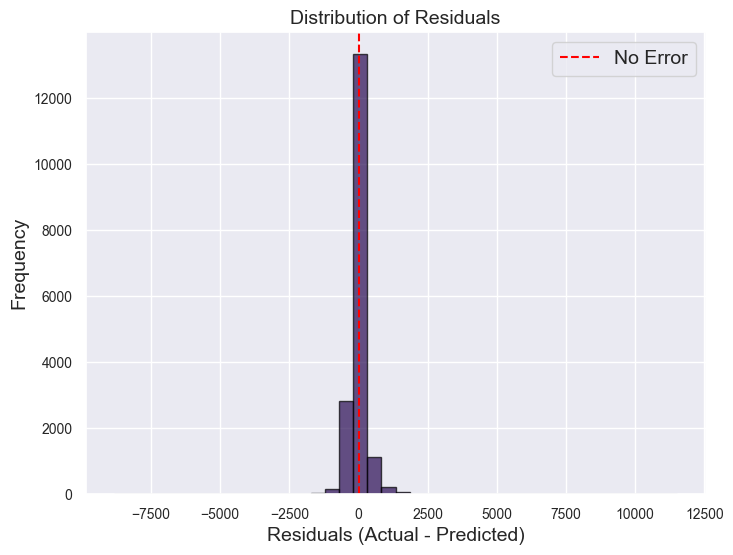

In [104]:
# Testing if errors have a normal distribution and if there are some systematic 
residuals = Y_test - final_predictions_test

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=40, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.grid(True)
plt.show()

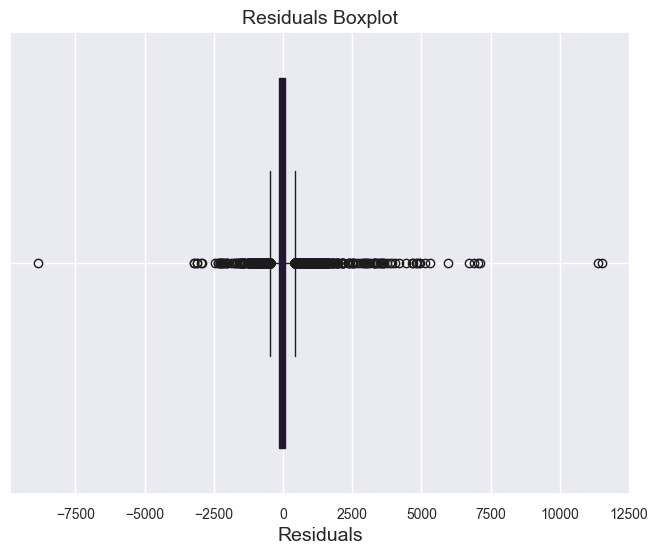

In [ ]:
# Boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(residuals, orient="h")
plt.title("Residuals Boxplot")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()


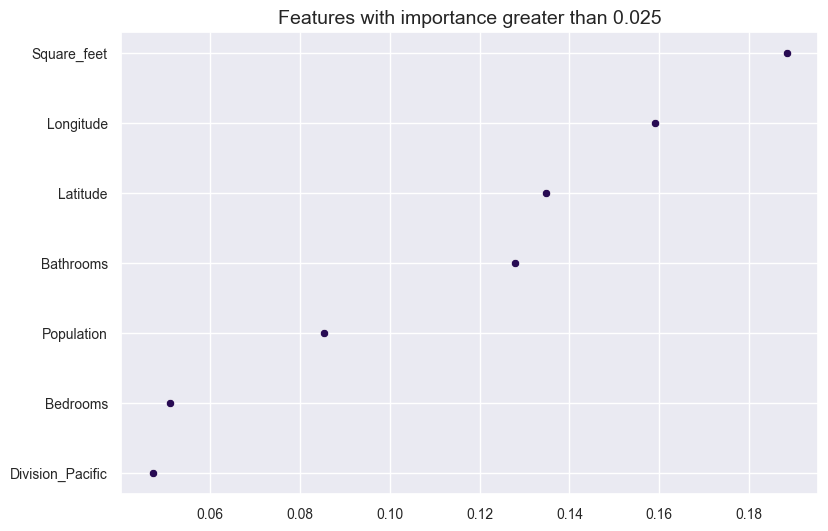

In [ ]:
# Fetching features' importance
feature_importances = best_forest_model.feature_importances_
features = X_test.columns

# creating df with features
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plotting importance scores for the most import ones
plt.figure(figsize=(9, 6))
sns.scatterplot(x="Importance", y="Feature", data=importance_df[importance_df['Importance']>0.025])
plt.title("Features with importance greater than 0.025")
plt.ylabel("")
plt.xlabel("")
plt.grid(True)
plt.show()


In [96]:
if api_key is not None:
    interpretation = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" Interpret the results of the final test of the Model: random forest regressor. Results of final test on test_data: Final test RMSE: {final_test_rmse},confidence interval for RMSE: {confidence_interval},final predictions: {final_predictions_test}. Test data: {test_set_labels}"}]                                                )
    print(interpretation.choices[0].message.content)